In [8]:
import pickle
import numpy as np

lr=0.03,
class NN(object):
    def __init__(self,
                 hidden_dims=(512, 256),
                 datapath='svhn.pkl',
                 n_classes=10,
                 epsilon=1e-6,
                 lr=7e-4,
                 batch_size=1000,
                 seed=None,
                 activation="relu",
                 init_method="glorot",
                 normalization=False
                 ):

        self.hidden_dims = hidden_dims
        self.n_hidden = len(hidden_dims)
        self.datapath = datapath
        self.n_classes = n_classes
        self.lr = lr
        self.batch_size = batch_size
        self.init_method = init_method
        self.seed = seed
        self.activation_str = activation
        self.epsilon = epsilon

        self.train_logs = {'train_accuracy': [], 'validation_accuracy': [], 'train_loss': [], 'validation_loss': []}

        if datapath is not None:
            u = pickle._Unpickler(open(datapath, 'rb'))
            u.encoding = 'latin1'
            self.train, self.valid, self.test = u.load()
            if normalization:
                self.normalize()
        else:
            self.train, self.valid, self.test = None, None, None

    def initialize_weights(self, dims):
        if self.seed is not None:
            np.random.seed(self.seed)
        
        self.weights = {}
        # self.weights is a dictionnary with keys W1, b1, W2, b2, ..., Wm, Bm where m - 1 is the number of hidden layers
        all_dims = [dims[0]] + list(self.hidden_dims) + [dims[1]]
        temp=dims[0]
#         print(all_dims)
#         print(self.n_hidden)
        for layer_n in range(1, self.n_hidden + 2):
            self.weights[f"W{layer_n}"] = np.random.uniform(-np.sqrt(6/(temp+all_dims[layer_n])), 
                                                           np.sqrt(6/(temp+all_dims[layer_n])), size=(temp,all_dims[layer_n]))
            self.weights[f"b{layer_n}"] = np.zeros((1, all_dims[layer_n]))

            temp=all_dims[layer_n]

    def relu(self, x, grad=False):
        temp_x=x.copy()
        if grad:
            temp_x[temp_x>0]=1
            temp_x[temp_x<0]=0
            return temp_x
        relu=np.maximum(0,x)
        return relu

    def sigmoid(self, x, grad=False):
        if grad:
            sig=1/(1+np.exp(-x))
            sig_grad=sig*(1-sig)
            return sig_grad
            
        sig=1/(1+np.exp(-x))
        return sig

    def tanh(self, x, grad=False):
        if grad:
            tanh=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
            tanh_grad=1-tanh**2
            return tanh_grad
        tanh=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

        return tanh

    def leakyrelu(self, x, grad=False):
        temp_xl=x.copy()
        alpha = 0.01
        if grad:
            temp_xl[temp_xl>0]=1
            temp_xl[temp_xl<=0]=alpha
            return temp_xl
        res=np.where( temp_xl>0, temp_xl, temp_xl*alpha)

        return res

    def activation(self, x, grad=False):
        if self.activation_str == "relu":
            return self.relu(x,grad)
        elif self.activation_str == "sigmoid":
            #return self.sigmoid(x,grad)
            return self.sigmoid(x,grad)
        elif self.activation_str == "tanh":
            return self.tanh(x,grad)
        elif self.activation_str == "leakyrelu":
            #return self.leakyrelu(x,grad)
            return self.leakyrelu(x,grad)
        else:
            raise Exception("invalid")
        return 0

    def softmax(self, x):
        # Remember that softmax(x-C) = softmax(x) when C is a constant.
        # WRITE CODE HERE
        #expA = np.exp(x)
        #return expA / expA.sum(axis=1, keepdims=True)

#     print(len(np.shape(x)))
        if len(np.shape(x))==1:
            expA = np.exp(x-np.max(x))
            return expA / expA.sum()

        expA = np.exp(x-np.max(x))
        return expA / expA.sum(axis=1, keepdims=True)
        
    def forward(self, x):
        cache = {"Z0": x}
        # cache is a dictionnary with keys Z0, A0, ..., Zm, Am where m - 1 is the number of hidden layers
        # Ai corresponds to the preactivation at layer i, Zi corresponds to the activation at layer i
        #print(self.n_hidden)
#         print(self.weights)
        #temp=cache[f"Z{0}"]
        for i in range(1,self.n_hidden+2):
            cache[f"A{i}"]=np.dot(cache[f"Z{i-1}"],self.weights[f"W{i}"])+self.weights[f"b{i}"]
            #self.activation(cache[f"Z{i-1}"])

            cache[f"Z{i}"] = self.activation(cache[f"A{i}"])
            #temp=cache[f"A{i}"]
        cache[f"Z{self.n_hidden+1}"]=self.softmax(cache[f"A{self.n_hidden+1}"])
        return cache

    def backward(self, cache, labels):
        output = cache[f"Z{self.n_hidden + 1}"]
        grads = {}
        # grads is a dictionnary with keys dAm, dWm, dbm, dZ(m-1), dA(m-1), ..., dW1, db1
        grads[f"dA{self.n_hidden + 1}"] =cache[f"Z{self.n_hidden+1}"] -labels 

        for i in range(self.n_hidden+1,0,-1):
#             print(i)
            if i!=self.n_hidden+1:
                grads[f"dA{i}"]=grads[f"dZ{i}"] * self.activation(cache[f"A{i}"],True  )
            
            grads[f"dW{i}"]= (1/self.batch_size)*np.dot(cache[f"Z{i-1}"].T , grads[f"dA{i}"])
            grads[f"db{i}"]=(1/self.batch_size)*np.sum(grads[f"dA{i}"] ,axis=0,keepdims=True)

            if i>1:

                grads[f"dZ{i-1}"]=np.dot(grads[f"dA{i}"],self.weights[f"W{i}"].T)
#                 print(grads[f"dZ{i-1}"])
#         print(grads.keys())    
        return grads
    def update(self, grads):
        for layer in range(1, self.n_hidden + 2):
            self.weights[f"W{layer}"]-=self.lr *grads[f"dW{layer}"]
            self.weights[f"b{layer}"]-=self.lr *grads[f"db{layer}"]

            pass

    def one_hot(self, y):

        onehot=np.zeros((len(y) ,self.n_classes))
        for index in range(len(y)):
            onehot[index][y[index]]=1

        return onehot

    def loss(self, prediction, labels):
        prediction[np.where(prediction < self.epsilon)] = self.epsilon
        prediction[np.where(prediction > 1 - self.epsilon)] = 1 - self.epsilon
        n_samples = labels.shape[0]
        logp = - np.log(prediction[np.arange(n_samples), labels.argmax(axis=1)])
        loss = np.sum(logp)/n_samples
        return loss

    def compute_loss_and_accuracy(self, X, y):
        one_y = self.one_hot(y)
        cache = self.forward(X)
        predictions = np.argmax(cache[f"Z{self.n_hidden + 1}"], axis=1)
        accuracy = np.mean(y == predictions)
        loss = self.loss(cache[f"Z{self.n_hidden + 1}"], one_y)
        return loss, accuracy, predictions

    def train_loop(self, n_epochs):
        X_train, y_train = self.train

        y_onehot = self.one_hot(y_train)
        dims = [X_train.shape[1], y_onehot.shape[1]]
        self.initialize_weights(dims)

        n_batches = int(np.ceil(X_train.shape[0] / self.batch_size))

        for epoch in range(n_epochs):
            for batch in range(n_batches):
                minibatchX = X_train[self.batch_size * batch:self.batch_size * (batch + 1), :]
                minibatchY = y_onehot[self.batch_size * batch:self.batch_size * (batch + 1), :]
                cache = self.forward(minibatchX)
                grad=self.backward(cache,minibatchY)
                self.update(grad)

            X_train, y_train = self.train
            train_loss, train_accuracy, _ = self.compute_loss_and_accuracy(X_train, y_train)
            X_valid, y_valid = self.valid
            valid_loss, valid_accuracy, _ = self.compute_loss_and_accuracy(X_valid, y_valid)
            print(epoch, train_loss, train_accuracy)
            self.train_logs['train_accuracy'].append(train_accuracy)
            self.train_logs['validation_accuracy'].append(valid_accuracy)
            self.train_logs['train_loss'].append(train_loss)
            self.train_logs['validation_loss'].append(valid_loss)

        return self.train_logs

    def evaluate(self):
        X_test, y_test = self.test
        loss,accuracy,pred=self.compute_loss_and_accuracy(X_test, y_test)
        return loss,accuracy

    def normalize(self):
        X_train, y_train = self.train
        print(X_train.shape)
        
        mean=np.mean(X_train,axis=0)
        stand=np.std(X_train,axis=0)
        
        X_train=(X_train-mean)/stand
        self.train=(X_train,y_train)
        
        X_valid, y_valid = self.valid
        X_valid=(X_valid-mean)/stand
        
        self.valid=(X_valid, y_valid )

        X_test, y_test = self.test
        X_test=(X_test-mean)/stand
        self.test=(X_test,y_test)
        


In [9]:
nn=NN(lr=0.03,batch_size=100,seed=0)
logs=nn.train_loop(30)

0 1.9227704489176534 0.3404925373134328
1 2.0777626913285716 0.29192537313432837
2 1.5197777888359043 0.4751791044776119
3 1.604422788943446 0.47634328358208955
4 1.112925950340138 0.6516567164179105
5 1.1023195315904015 0.6535522388059701
6 1.381831156766577 0.5624776119402985
7 0.9321369899679496 0.7095373134328358
8 1.0333050123661396 0.6742089552238806
9 0.9341088598073987 0.7064179104477611
10 0.8977922281207517 0.7159552238805971
11 0.8405394261402774 0.7390746268656716
12 0.8291684163186792 0.7437164179104477
13 0.784266977777644 0.7617164179104478
14 0.7817325138667081 0.7595970149253731
15 0.823830732198266 0.7495373134328358
16 0.7144828085828582 0.7824328358208955
17 0.7172958692725012 0.782910447761194
18 0.7370748249985027 0.7774328358208955
19 0.701797321161379 0.7873880597014925
20 0.7074622708260337 0.786910447761194
21 0.7006578458804208 0.7889850746268656
22 0.6703040667937918 0.7985522388059701
23 0.6643520849896746 0.7986716417910448
24 0.6628133490413426 0.79823880

Text(0.5, 1.0, 'Accuracy Graph')

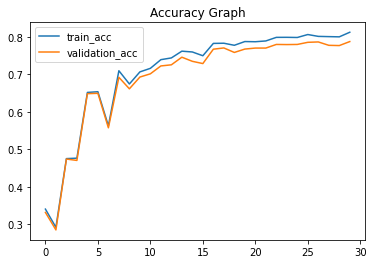

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(logs['train_accuracy'])
plt.plot(logs['validation_accuracy'])
plt.legend(['train_acc','validation_acc'])
plt.title('Accuracy Graph')

Text(0.5, 1.0, 'Loss Graph')

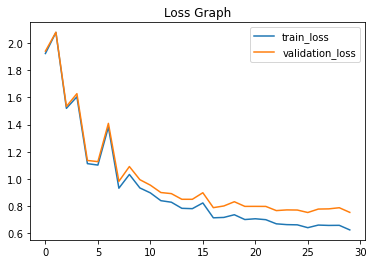

In [11]:
plt.plot(logs['train_loss'])
plt.plot(logs['validation_loss'])
plt.legend(['train_loss','validation_loss'])
plt.title('Loss Graph')

In [12]:

nn2_norm=NN(lr=0.03,batch_size=100,normalization=True,seed=0)

logs2_norm=nn2_norm.train_loop(30)



(67000, 3072)
0 0.9725198053399885 0.6961492537313433
1 0.757441023293198 0.7672985074626866
2 0.6555994410568774 0.8005671641791045
3 0.5875882763744327 0.8218358208955224
4 0.5500590970121548 0.8327164179104478
5 0.5178340279819417 0.8424477611940299
6 0.4900629594347692 0.851089552238806
7 0.4578281248020571 0.8598955223880597
8 0.44828269201596277 0.8622835820895522
9 0.42687029504081886 0.870955223880597
10 0.424016395478108 0.8709402985074627
11 0.3872890022960362 0.8812089552238807
12 0.3722989374316618 0.8854328358208955
13 0.3703325772538981 0.8859402985074627
14 0.35844428006825413 0.8893432835820896
15 0.348824822806603 0.8929850746268657
16 0.3650320104709863 0.8885671641791045
17 0.3353337633211576 0.897686567164179
18 0.3114639819869796 0.903910447761194
19 0.31952604302858906 0.9024328358208955
20 0.32397415393181617 0.9019850746268657
21 0.2629274538485211 0.9180746268656717
22 0.25542036645371874 0.9199701492537313
23 0.24340821393629974 0.9247462686567164
24 0.2632997

Text(0.5, 1.0, 'Accuracy Graph')

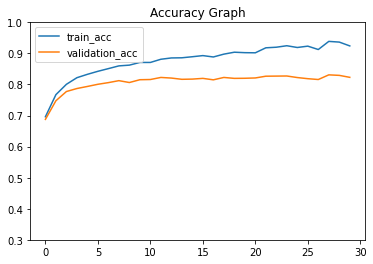

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(logs2_norm['train_accuracy'])
plt.plot(logs2_norm['validation_accuracy'])
plt.ylim(0.3, 1) 
plt.legend(['train_acc','validation_acc'])
plt.title('Accuracy Graph')

Text(0.5, 1.0, 'Loss Graph')

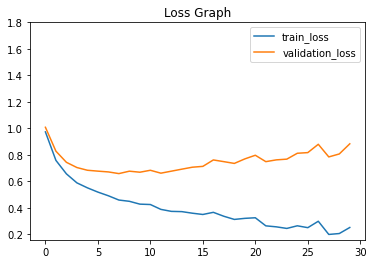

In [29]:
plt.plot(logs2_norm['train_loss'])
plt.plot(logs2_norm['validation_loss'])
plt.yticks(np.arange(0.2,2,step=0.2))
plt.legend(['train_loss','validation_loss'])
plt.title('Loss Graph')

In [18]:
#New neural net

nn3=NN(lr=0.03,batch_size=100,hidden_dims=(512,120,120,120,120,120),seed=0)
logs3norm=nn3.train_loop(30)

0 1.84942357194681 0.3653731343283582
1 1.7788695967420443 0.39332835820895523
2 1.4437113078550545 0.5245970149253731
3 1.475303498492972 0.5094029850746269
4 1.1434842028263017 0.6334328358208955
5 1.031571171905252 0.6736119402985075
6 1.0720292888660898 0.6578955223880597
7 0.9722165011663151 0.6906716417910448
8 0.8987265560298014 0.7200597014925373
9 0.8432639451340728 0.7323283582089553
10 0.8529050567569834 0.7288059701492537
11 0.7939764025715463 0.7486268656716418
12 0.8297218243793495 0.7371343283582089
13 0.8667290444584279 0.7272985074626865
14 0.8988270364463435 0.7173432835820895
15 0.8302021885825215 0.7318656716417911
16 0.8319552605850955 0.7343283582089553
17 0.8676769574852335 0.7326716417910448
18 0.7042799460006205 0.7767761194029851
19 0.783748004085137 0.75
20 0.7070139162790645 0.7796268656716417
21 0.6248347885489258 0.8005970149253732
22 0.710992226034958 0.775
23 0.6127685168819988 0.8073582089552239
24 0.5905554674860979 0.813089552238806
25 0.6403223221073

Text(0.5, 1.0, 'Accuracy Graph')

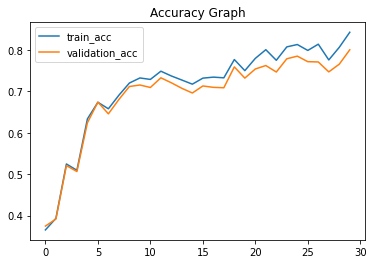

In [30]:
plt.plot(logs3norm['train_accuracy'])
plt.plot(logs3norm['validation_accuracy'])
plt.legend(['train_acc','validation_acc'])
plt.title('Accuracy Graph')

Text(0.5, 1.0, 'Loss Graph')

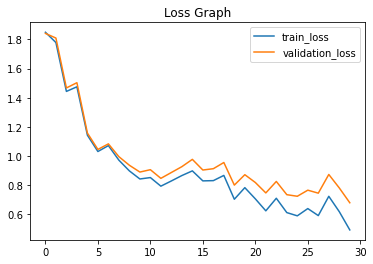

In [31]:
plt.plot(logs3norm['train_loss'])
plt.plot(logs3norm['validation_loss'])

plt.legend(['train_loss','validation_loss'])
plt.title('Loss Graph')

In [35]:
hidden_dims=(512,120,120,120,120,120)
len(hidden_dims)

6